#### Citations:
Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

### Module imports

In [1]:
import numpy as np 
import pandas as pd

import re # regular expresions
import html.parser #the basis for parsing text files formatted in HTML (HyperText Mark-up Language) and XHTML.

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data imports and processing

In [2]:
dataset = pd.read_csv('./vienna_data/reviews_polarity.csv')

In [3]:
dataset.head()

,listing_id,reviewer_id,comments,Positive,Negative,Neutral,Compound
0,15883,30537860,"If you need a clean, comfortable place to stay...",24.1,5.8,70.0,94.80
1,15883,37529754,It's so nice to be in the house! It's a peace ...,53.4,0.0,46.6,96.04
2,15883,3147341,"A beautiful place, uniquely decorated showing ...",22.4,5.2,72.4,92.98
3,15883,29518067,Eine sehr schöne Unterkunft in einem privaten ...,0.0,0.0,100.0,0.00
4,15883,36016357,It was a very pleasant stay. Excellent locatio...,62.2,0.0,37.8,92.08


In [4]:
dataset.isna().sum()

listing_id     0
reviewer_id    0
comments       0
Positive       0
Negative       0
Neutral        0
Compound       0
dtype: int64

## Reviews and polarity scores dataset

As it can be seen from the table below, each comment has it's polarity scores calculated (multiplied by 100) - positive, negative, neutral and the compound polarity score. For non-english reviews, the "sentiment" is neutral 100%. 

The compound metric ('normalized, weighted composite score') will be useful for the next step - generating word clouds for most positive / negative reviews. 

From the scoring method related to the compound score (it can be seen [here](https://github.com/cjhutto/vaderSentiment#about-the-scoring)), typical threshold values are:

+ positive sentiment: compound score >= 0.05
+ neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
+ negative sentiment: compound score <= -0.05

The scoring method related to the "compound" metric can be seen [here](https://github.com/cjhutto/vaderSentiment#about-the-scoring).


In [5]:
dataset.tail(20)

,listing_id,reviewer_id,comments,Positive,Negative,Neutral,Compound
469959,42642091,299008765,La estancia fue increíble. Nos dejaron cosas p...,0.0,0.0,100.0,0.00
469960,42665072,14455623,The apartment is clean and simple. You have to...,4.1,7.4,88.6,-29.60
469961,42665072,6036216,"Very cute and great apartment, price vs value ...",22.2,0.0,77.8,97.05
469962,42665072,196311212,This accommodation is not so far from Vienna h...,12.9,0.0,87.1,64.59
469963,42666433,126455592,Me and my friend really liked it We loved it ❤️,56.0,0.0,44.0,88.05
469964,42667250,141082281,"Super nette Gastgeberin, kleine feine Wohnung,...",36.0,0.0,64.0,73.51
469965,42667250,30923871,Leticia ist sehr nett und hilfsbereit. Die Woh...,7.5,14.6,78.0,-49.12
469966,42667250,224507883,The host canceled this reservation 21 days bef...,0.0,0.0,100.0,0.00
469967,42667250,33800333,The host canceled this reservation 23 days bef...,0.0,0.0,100.0,0.00
469968,42667250,294752327,The host canceled this reservation 27 days bef...,0.0,0.0,100.0,0.00


### Automated reviews - cancelation of reservation

There are 3319 automated postings in the dataset - having a fully neutral polarity score. 

When a host cancels a confirmed reservation, Airbnb imposes several penalties, this being one of them. This is useful for future clients on Arbnb regarding hosts that have a tendecy to cancel reservations.

These reviews will be excluded from the dataset.

In [6]:
automated_postings = dataset[dataset.comments.str.contains(pat = 'automated posting', case=False)]
len(automated_postings)

3319

In [7]:
len(dataset)

469979

In [8]:
automated_postings.reset_index(drop=True, inplace = True)

In [9]:
with pd.option_context('display.max_colwidth', None): 
    print(automated_postings.head(10))

   listing_id  reviewer_id  \
0       51287     51044143   
1       70637      4164818   
2       70637     29271569   
3       70637     21273606   
4       75500    153855455   
5       75500      6510149   
6       78416      9289349   
7       78416     61913378   
8       78416    171257619   
9       78416    250404105   

                                                                                    comments  \
0   The host canceled this reservation 13 days before arrival. This is an automated posting.   
1         The reservation was canceled 54 days before arrival. This is an automated posting.   
2         The reservation was canceled 23 days before arrival. This is an automated posting.   
3    The host canceled this reservation 3 days before arrival. This is an automated posting.   
4   The host canceled this reservation 65 days before arrival. This is an automated posting.   
5  The host canceled this reservation 114 days before arrival. This is an automated posting. 

In [10]:
automated_postings.listing_id.value_counts()

14621711    16
5835467     13
18102062    13
28019001    10
20489681    10
            ..
19470814     1
41466336     1
9247202      1
5601764      1
29736960     1
Name: listing_id, Length: 2179, dtype: int64

There are few listings with more than 10 such cancelation-related automated postings. Most of the listings have 1 or 2 such reviews.

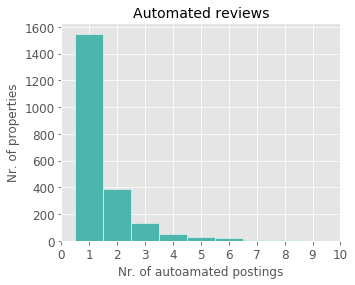

In [11]:
plt.figure(figsize = (5,4))

plt.hist(automated_postings.listing_id.value_counts(), bins = np.arange(10)-0.5, ec = 'white', color = '#4db6ac')

plt.title('Automated reviews', fontsize= 14)
plt.xlabel('Nr. of autoamated postings', fontsize = 12)
plt.ylabel('Nr. of properties',fontsize = 12)

plt.xticks(range(17), fontsize = 12)
plt.xlim([0, 10])
plt.yticks(fontsize = 12)
plt.show()

In [12]:
# Dropping these rows
indexNames = dataset[dataset.comments.str.contains(pat = 'automated posting', case=False)].index
# Delete these row indexes from dataFrame
dataset.drop(indexNames , inplace=True)


In [13]:
dataset[dataset.comments.str.contains(pat = 'automated posting', case=False)]

,listing_id,reviewer_id,comments,Positive,Negative,Neutral,Compound


In [14]:
len(dataset)

466660

In [18]:
dataset.drop(['Positive', 'Negative', "Neutral"], axis = 1, inplace=True)

In [19]:
dataset.head()

,listing_id,reviewer_id,comments,Compound
0,15883,30537860,"If you need a clean, comfortable place to stay...",94.80
1,15883,37529754,It's so nice to be in the house! It's a peace ...,96.04
2,15883,3147341,"A beautiful place, uniquely decorated showing ...",92.98
3,15883,29518067,Eine sehr schöne Unterkunft in einem privaten ...,0.00
4,15883,36016357,It was a very pleasant stay. Excellent locatio...,92.08


In [20]:
# define function for cleaning reviews sentences 
def clean_data(textData):
    textData = re.sub(r'[?|$|.|!|&|\r|\n|;|-|,|:|\d+]', r' ', textData)
    textData = html.parser.unescape(textData)
    return textData

In [21]:
length = len(dataset.comments)
length

466660

In [22]:
#clean reviews
length = len(dataset.comments)
print("Review count",length)
for i in range(0,length):
    dataset.comments.values[i] = clean_data(dataset.comments.values[i])

Review count 466660


In [23]:
dataset.head()

,listing_id,reviewer_id,comments,Compound
0,15883,30537860,If you need a clean comfortable place to stay...,94.80
1,15883,37529754,It's so nice to be in the house It's a peace ...,96.04
2,15883,3147341,A beautiful place uniquely decorated showing ...,92.98
3,15883,29518067,Eine sehr schöne Unterkunft in einem privaten ...,0.00
4,15883,36016357,It was a very pleasant stay Excellent locatio...,92.08


In [73]:
dataset.to_csv('./vienna_data/processed_reviews.csv',index=False)